In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import argparse
import os

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix
from scipy.io import mmread, mmwrite
from scipy import stats
from sklearn import metrics

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['font.serif'] = ['Arial']
# # matplotlib.rcParams['font.serif'] = ['SimHei']
# sc.settings.set_figure_params(dpi=150,dpi_save=300,facecolor='white',fontsize=10,figsize=(3,3))
matplotlib.rcParams['font.serif'] = ['Arial']

import warnings
warnings.filterwarnings("ignore")

# Load data #

In [2]:
train_id = "24"
test_id = "23"
data_path = "../dataset/dataset"

In [3]:
true_data_path = data_path + test_id +"_adata.h5ad"
test_data = sc.read(true_data_path)
true_data = test_data.obsm['protein_expression']
true_data.columns = true_data.columns.str.replace("-","_")
true_data.columns = true_data.columns.str.replace(".","_")

In [4]:
train_data = sc.read(data_path + train_id +"_adata.h5ad")
train_data.obsm['protein_expression'].columns = train_data.obsm['protein_expression'].columns.str.replace("-","_")
train_data.obsm['protein_expression'].columns = train_data.obsm['protein_expression'].columns.str.replace(".","_")

In [5]:
totalVI_path = "../Results/"+ test_id + "_from_" + train_id + "_totalVI.csv"
scArches_path = "../Results/" + test_id + "_from_" + train_id + "_scArches.csv"
Dengkw_path = "../Results/" + test_id + "_from_" + train_id + "_Dengkw.csv"
cTp_net_path = "../Results/" + test_id + "_from_" + train_id + "_cTPnet.csv"
scMoGNN_path = "../Results/" + test_id + "_from_" + train_id + "_scMoGNN.csv"
Seurat_path = "../Results/" + test_id + "_from_" + train_id + "_seurat.csv"
Liger_path = "../Results/" + test_id + "_from_" + train_id + "_Liger.csv"
BABEL_path = "../Results/" + test_id + "_from_" + train_id + "_babel.csv"
CMAE_path = "../Results/" + test_id + "_from_" + train_id + "_cmae.csv"
sciPENN_path = "../Results/" + test_id + "_from_" + train_id + "_sciPENN.csv"
scVAEIT_path = "../Results/" + test_id + "_from_" + train_id + "_scVAEIT.csv"

In [6]:
totalVI_pre = pd.read_csv(totalVI_path,index_col = 0)
scArches_pre = pd.read_csv(scArches_path,index_col = 0)
Dengkw_pre = pd.read_csv(Dengkw_path,index_col = 0)
cTp_net_pre = pd.read_csv(cTp_net_path,index_col = 0).T
scMoGNN_pre = pd.read_csv(scMoGNN_path,index_col = 0).T
Seurat_pre = pd.read_csv(Seurat_path,index_col = 0).T
Liger_pre = pd.read_csv(Liger_path,index_col = 0).T
BABEL_pre = pd.read_csv(BABEL_path,index_col = 0).T
CMAE_pre = pd.read_csv(CMAE_path,index_col = 0).T
sciPENN_pre = pd.read_csv(sciPENN_path,index_col = 0)
scVAEIT_pre = pd.read_csv(scVAEIT_path,index_col = 0)

In [7]:
totalVI_pre.columns = totalVI_pre.columns.str.replace("-","_")
totalVI_pre.columns = totalVI_pre.columns.str.replace(".","_")
scArches_pre.columns = scArches_pre.columns.str.replace("-","_")
Dengkw_pre.columns = Dengkw_pre.columns.str.replace("-","_")
cTp_net_pre.columns = cTp_net_pre.columns.str.replace("-","_")
Seurat_pre.columns = Seurat_pre.columns.str.replace("-","_")
Seurat_pre.columns = Seurat_pre.columns.str.replace(".","_")
Liger_pre.columns = Liger_pre.columns.str.replace("-","_")
Liger_pre.columns = Liger_pre.columns.str.replace(".","_")
sciPENN_pre.columns = sciPENN_pre.columns.str.replace("-","_")
sciPENN_pre.columns = sciPENN_pre.columns.str.replace(".","_")
scVAEIT_pre.columns = scVAEIT_pre.columns.str.replace("-","_")
scVAEIT_pre.columns = scVAEIT_pre.columns.str.replace(".","_")

In [8]:
proteins_inter = train_data.obsm['protein_expression'].columns.intersection(true_data.columns)

In [9]:
scMoGNN_pre = pd.DataFrame(data = scMoGNN_pre.values, index = true_data.index , columns = proteins_inter)
CMAE_pre = pd.DataFrame(data = CMAE_pre.values, index = true_data.index , columns = train_data.obsm['protein_expression'].columns)
CMAE_pre = CMAE_pre[proteins_inter]
BABEL_pre = pd.DataFrame(data = BABEL_pre.values, index = true_data.index , columns = train_data.obsm['protein_expression'].columns)
BABEL_pre = BABEL_pre[proteins_inter]
totalVI_pre = totalVI_pre[proteins_inter]
scArches_pre = scArches_pre[proteins_inter]
Dengkw_pre = Dengkw_pre[proteins_inter]
cTp_net_pre = cTp_net_pre[proteins_inter]
Seurat_pre = Seurat_pre[proteins_inter]
Liger_pre = Liger_pre[proteins_inter]
sciPENN_pre = sciPENN_pre[proteins_inter]
sciPENN_pre = sciPENN_pre[proteins_inter]
true_data = true_data[proteins_inter]

In [10]:
print(scMoGNN_pre.shape)
print(totalVI_pre.shape)
print(scArches_pre.shape)
print(Dengkw_pre.shape)
print(cTp_net_pre.shape)
print(Seurat_pre.shape)
print(Liger_pre.shape)
print(BABEL_pre.shape)
print(CMAE_pre.shape)
print(sciPENN_pre.shape)

(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)
(3158, 48)


# compute PCCs #

### totalVI ###

In [11]:
totalVI_pcc_protein = []
for i in range(totalVI_pre.shape[1]):
    x = np.array(totalVI_pre[totalVI_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    totalVI_pcc_protein.append(pcc)
totalVI_pcc_cell = []
for i in range(totalVI_pre.shape[0]):
    x = np.array((totalVI_pre.T)[totalVI_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    totalVI_pcc_cell.append(pcc)

### scArches ###

In [12]:
scArches_pcc_protein = []
for i in range(scArches_pre.shape[1]):
    x = np.array(scArches_pre[scArches_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    scArches_pcc_protein.append(pcc)
scArches_pcc_cell = []
for i in range(scArches_pre.shape[0]):
    x = np.array((scArches_pre.T)[scArches_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    scArches_pcc_cell.append(pcc)

### Guanlab-dengkw ###

In [13]:
Dengkw_pcc_protein = []
for i in range(Dengkw_pre.shape[1]):
    x = np.array(Dengkw_pre[Dengkw_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    Dengkw_pcc_protein.append(pcc)
Dengkw_pcc_cell = []
for i in range(Dengkw_pre.shape[0]):
    x = np.array((Dengkw_pre.T)[Dengkw_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    Dengkw_pcc_cell.append(pcc)

### cTP-net ###

In [14]:
clr_true = true_data.apply(lambda x: np.log((x+1.0)/stats.gmean(x+1.0)), axis=0)

In [15]:
cTp_net_pcc_protein = []
for i in range(cTp_net_pre.shape[1]):
    x = np.array(cTp_net_pre[cTp_net_pre.columns[i]])
    y = np.array(clr_true[clr_true.columns[i]])    
    pcc = pearsonr(x,y)[0]
    cTp_net_pcc_protein.append(pcc)
cTp_net_pcc_cell = []
for i in range(cTp_net_pre.shape[0]):
    x = np.array((cTp_net_pre.T)[cTp_net_pre.index[i]])
    y = np.array((clr_true.T)[clr_true.index[i]])    
    pcc = pearsonr(x,y)[0]
    cTp_net_pcc_cell.append(pcc)

### scMoGNN ###

In [16]:
scMoGNN_pcc_protein = []
for i in range(scMoGNN_pre.shape[1]):
    x = np.array(scMoGNN_pre[scMoGNN_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    scMoGNN_pcc_protein.append(pcc)
scMoGNN_pcc_cell = []
for i in range(scMoGNN_pre.shape[0]):
    x = np.array((scMoGNN_pre.T)[scMoGNN_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    scMoGNN_pcc_cell.append(pcc)

### Seurat ###

In [17]:
clr_true = true_data.apply(lambda x: np.log((x+1.0)/stats.gmean(x+1.0)), axis=0)

In [18]:
Seurat_pcc_protein = []
for i in range(Seurat_pre.shape[1]):
    x = np.array(Seurat_pre[Seurat_pre.columns[i]])
    y = np.array(clr_true[clr_true.columns[i]])    
    pcc = pearsonr(x,y)[0]
    Seurat_pcc_protein.append(pcc)
Seurat_pcc_cell = []
for i in range(Seurat_pre.shape[0]):
    x = np.array((Seurat_pre.T)[Seurat_pre.index[i]])
    y = np.array((clr_true.T)[clr_true.index[i]])    
    pcc = pearsonr(x,y)[0]
    Seurat_pcc_cell.append(pcc)

### LIGER ##

In [19]:
Liger_pcc_protein = []
for i in range(Liger_pre.shape[1]):
    x = np.array(Liger_pre[Liger_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    Liger_pcc_protein.append(pcc)
Liger_pcc_cell = []
for i in range(Liger_pre.shape[0]):
    x = np.array((Liger_pre.T)[Liger_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    Liger_pcc_cell.append(pcc)

### BABEL ###

In [20]:
BABEL_pcc_protein = []
for i in range(BABEL_pre.shape[1]):
    x = np.array(BABEL_pre[BABEL_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    BABEL_pcc_protein.append(pcc)
BABEL_pcc_cell = []
for i in range(BABEL_pre.shape[0]):
    x = np.array((BABEL_pre.T)[BABEL_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    BABEL_pcc_cell.append(pcc)

### CMAE ##

In [21]:
CMAE_pcc_protein = []
for i in range(CMAE_pre.shape[1]):
    x = np.array(CMAE_pre[CMAE_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    CMAE_pcc_protein.append(pcc)
CMAE_pcc_cell = []
for i in range(CMAE_pre.shape[0]):
    x = np.array((CMAE_pre.T)[CMAE_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    CMAE_pcc_cell.append(pcc)

### sciPENN

In [22]:
A = ad.AnnData(X = true_data).copy()
sc.pp.normalize_total(A)
sc.pp.log1p(A)
sc.pp.scale(A)

B = pd.DataFrame(data = A.X,columns = A.var_names,index = A.obs_names)

C = (B.T[sciPENN_pre.index]).T

In [23]:
sciPENN_scale = ad.AnnData(sciPENN_pre)
sc.pp.scale(sciPENN_scale)
sciPENN_scale = pd.DataFrame(data = sciPENN_scale.X,columns = sciPENN_scale.var_names,index = sciPENN_scale.obs_names)

In [24]:
sciPENN_pcc_protein = []
for i in range(sciPENN_scale.shape[1]):
    x = np.array(sciPENN_scale[sciPENN_scale.columns[i]])
    y = np.array(C[C.columns[i]])    
    pcc = pearsonr(x,y)[0]
    sciPENN_pcc_protein.append(pcc)
sciPENN_pcc_cell = []
for i in range(sciPENN_scale.shape[0]):
    x = np.array((sciPENN_scale.T)[sciPENN_scale.index[i]])
    y = np.array((C.T)[C.index[i]])    
    pcc = pearsonr(x,y)[0]
    sciPENN_pcc_cell.append(pcc)

### scVAEIT

In [25]:
Y = true_data.values
true_data_after = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
true_data_after = pd.DataFrame(data = true_data_after,index= true_data.index,columns=true_data.columns)

In [26]:
scVAEIT_pcc_protein = []
for i in range(scVAEIT_pre.shape[1]):
    x = np.array(scVAEIT_pre[scVAEIT_pre.columns[i]])
    y = np.array(true_data_after[true_data_after.columns[i]])    
    pcc = pearsonr(x,y)[0]
    scVAEIT_pcc_protein.append(pcc)
scVAEIT_pcc_cell = []
for i in range(scVAEIT_pre.shape[0]):
    x = np.array((scVAEIT_pre.T)[scVAEIT_pre.index[i]])
    y = np.array((true_data_after.T)[true_data_after.index[i]])    
    pcc = pearsonr(x,y)[0]
    scVAEIT_pcc_cell.append(pcc)

### Summary PCC results

In [27]:
my_pal = {'totalVI':'#E6D885','scArches':'#F1C67F','Dengkw':'#E7A365','scMoGNN':'#EE9185','CMAE':'#E2A6C0','BABEL':'#BEABCB','Seurat':'#7DC9C4','sciPENN':'#84a4e8','Liger':'#65AADD','cTp_net':'#7CC38A','scVAEIT':'c'}


In [28]:
index = ['totalVI','scArches','Dengkw','cTp_net','scMoGNN','Seurat','Liger','BABEL','CMAE','sciPENN','scVAEIT']
pro_columns = true_data.columns
cell_columns = true_data.index
PCCs_protein = pd.DataFrame([totalVI_pcc_protein,scArches_pcc_protein,Dengkw_pcc_protein,cTp_net_pcc_protein,scMoGNN_pcc_protein,Seurat_pcc_protein,Liger_pcc_protein,BABEL_pcc_protein,CMAE_pcc_protein,sciPENN_pcc_protein,scVAEIT_pcc_protein],index = index,columns = pro_columns)
PCCs_cell = pd.DataFrame([totalVI_pcc_cell,scArches_pcc_cell,Dengkw_pcc_cell,cTp_net_pcc_cell,scMoGNN_pcc_cell,Seurat_pcc_cell,Liger_pcc_cell,BABEL_pcc_cell,CMAE_pcc_cell,sciPENN_pcc_cell,scVAEIT_pcc_cell],index = index,columns = cell_columns)


In [29]:
PCCs_protein.to_csv("../Results/"+ test_id + "_from_" + train_id +"_pcc_protein.csv")
PCCs_cell.to_csv("../Results/"+ test_id + "_from_" + train_id +"_pcc_cell.csv")

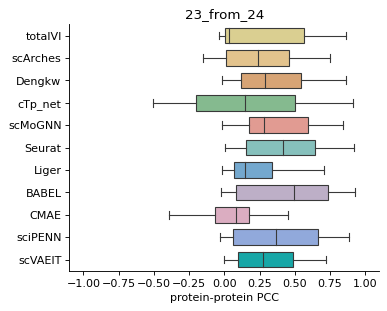

In [30]:
font = {'family':'DejaVu Sans','weight':'normal','size':15}
plt.figure(figsize=(5,4), dpi= 80)
fig1 = sns.boxplot(data=PCCs_protein.T,orient = "h",linewidth=1,width=0.7, palette=my_pal,fliersize=0,flierprops = {'marker':'o'})
fig1.set_xlabel("protein-protein PCC")
fig1.set_xlim(-1.1,1.1)
fig1.spines['top'].set_visible(False)
fig1.spines['right'].set_visible(False)
plt.title(test_id + "_from_" + train_id, fontdict={'size': 12})
# plt.savefig("../Results/"+ test_id + "_from_" + train_id +"_pcc_protein.pdf", bbox_inches="tight")
plt.show()

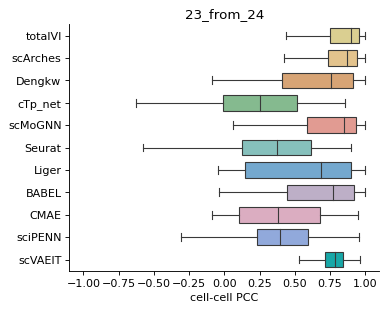

In [31]:
font = {'family':'DejaVu Sans','weight':'normal','size':15}
plt.figure(figsize=(5,4), dpi= 80)
fig2 = sns.boxplot(data=PCCs_cell.T,orient = "h",linewidth=1,width=0.7, palette=my_pal,fliersize=0,flierprops = {'marker':'o'})
fig2.set_xlabel("cell-cell PCC")
fig2.set_xlim(-1.1,1.1)
fig2.spines['top'].set_visible(False)
fig2.spines['right'].set_visible(False)
plt.title(test_id + "_from_" + train_id, fontdict={'size': 12})
# plt.savefig("../Results/"+ test_id + "_from_" + train_id +"_pcc_cell.pdf", bbox_inches="tight")
plt.show()

# Compute CMDs #

In [32]:
List = ['totalVI_pre','scArches_pre','Dengkw_pre','cTp_net_pre','scMoGNN_pre','Seurat_pre','Liger_pre','BABEL_pre','CMAE_pre','sciPENN_pre','scVAEIT_pre']
index = ['totalVI','scArches','Dengkw','cTp_net','scMoGNN','Seurat','Liger','BABEL','CMAE','sciPENN','scVAEIT']

In [33]:
def CMD_dist(A, B):
    a = np.multiply(A,B).sum()
    # a = np.trace(A.dot(B))
    b = np.linalg.norm(A,'fro')*np.linalg.norm(B,'fro')
    return 1- a/(b+1e-8)

In [34]:
# compute cmd_cell
true_corr = true_data.T.corr()
true_corr.dropna(how='all',axis = 1,inplace = True)
true_corr.dropna(how='all',inplace = True)

cmd_cell = []

for i in range(len(List)):
    if List[i] == 'sciPENN_pre':
        A = sciPENN_scale.T.corr()
        B = C.T.corr()
        B.dropna(how='all',axis = 1,inplace = True)
        B.dropna(how='all',inplace = True)
    elif List[i] == 'scVAEIT_pre':
        A = scVAEIT_pre.T.corr()
        B = true_data_after.T.corr()
        B.dropna(how='all',axis = 1,inplace = True)
        B.dropna(how='all',inplace = True)
    else:
        A = eval(List[i]).T.corr()
        B = true_corr

    A.dropna(how='all',axis = 1,inplace = True)
    A.dropna(how='all',inplace = True)
    
    inter_cell = A.index.intersection(B.index)
    B = B[inter_cell]
    B = (B.T)[inter_cell].T
    
    A = A[inter_cell]
    A = (A.T)[inter_cell].T
    
    cmd = CMD_dist(A.values.T,B.values)

    cmd_cell.append(cmd)

CMD_cell = pd.DataFrame(data = cmd_cell, index = index,columns = ['cmd_values'])

In [35]:
# compute cmd_protein
true_protein_corr = true_data.corr()
true_protein_corr.dropna(how='all',axis = 1,inplace = True)
true_protein_corr.dropna(how='all',inplace = True)

cmd_protein = []
for i in range(len(List)):
    if List[i] == 'sciPENN_pre':
        A = sciPENN_scale.corr()
        B = C.corr()
        B.dropna(how='all',axis = 1,inplace = True)
        B.dropna(how='all',inplace = True)
    elif List[i] == 'scVAEIT_pre':
        A = scVAEIT_pre.corr()
        B = true_data_after.corr()
        B.dropna(how='all',axis = 1,inplace = True)
        B.dropna(how='all',inplace = True)
    else:
        A = eval(List[i]).corr()
        B = true_protein_corr

    A.dropna(how='all',axis = 1,inplace = True)
    A.dropna(how='all',inplace = True)
    
    inter_cell = A.columns.intersection(B.columns)
    inter_gene = A.index.intersection(B.index)
    B = B[inter_cell]
    B = (B.T)[inter_gene].T
    
    A = (A.T)[inter_gene].T
    A = A[inter_cell]

    cmd = CMD_dist(A.values.T,B.values)

    cmd_protein.append(cmd)

CMD_protein = pd.DataFrame(data = cmd_protein, index = index,columns = ['cmd_values'])

In [36]:
CMD_cell.to_csv("../Results/"+ test_id + "_from_" + train_id +"_cmd_cell.csv")
CMD_protein.to_csv("../Results/"+ test_id + "_from_" + train_id +"_cmd_protein.csv")

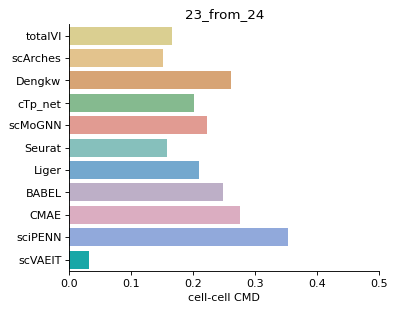

In [37]:
font = {'family':'DejaVu Sans','weight':'normal','size':15}
plt.figure(figsize=(5,4), dpi= 80)
fig3 = sns.barplot(x = "cmd_values",y = index,orient = "h",data = CMD_cell, ci = 95, palette = my_pal)
fig3.set_xlabel("cell-cell CMD")
fig3.spines['top'].set_visible(False)
fig3.spines['right'].set_visible(False)
fig3.set_xticks(np.arange(0,0.55,0.1))
plt.title(test_id + "_from_" + train_id, fontdict={'size': 12})
# plt.savefig("../Results/new_pictures/Twobatches/"+ test_id + "_from_" + train_id +"_cmd_cell.pdf", bbox_inches="tight")
plt.show()

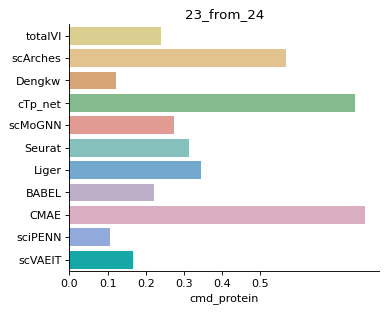

In [38]:
font = {'family':'DejaVu Sans','weight':'normal','size':15}
plt.figure(figsize=(5,4), dpi= 80)
fig4 = sns.barplot(x = "cmd_values",y = index,orient = "h",data = CMD_protein, ci = 95, palette = my_pal)
fig4.set_xlabel("cmd_protein")
fig4.spines['top'].set_visible(False)
fig4.spines['right'].set_visible(False)
fig4.set_xticks(np.arange(0,0.55,0.1))
plt.title(test_id + "_from_" + train_id, fontdict={'size': 12})
# plt.savefig("../Results/"+ test_id + "_from_" + train_id +"_cmd_protein.pdf", bbox_inches="tight")
plt.show()

# Compute RMSE

In [39]:
def RMSE(true,pred):
    true_array = np.array(true,dtype=np.float32).flatten()
    pred_array = np.array(pred,dtype=np.float32).flatten() 
    rmse = metrics.mean_squared_error(true_array, pred_array)**0.5
    return rmse

In [40]:
method_list = ['totalVI','scArches','Dengkw','cTp_net','scMoGNN','Seurat','Liger','BABEL','CMAE','sciPENN','scVAEIT']

In [41]:
## compute
for i in range(len(method_list)):
    A = ad.AnnData(X = true_data).copy()
    sc.pp.normalize_total(A)
    sc.pp.log1p(A)
    sc.pp.scale(A)

    B = pd.DataFrame(data = A.X,columns = A.var_names,index = A.obs_names)    
    
    name = method_list[i]
    print(name)
    if name in ['Seurat','cTp_net']:
        temp = eval(name+'_pre').apply(lambda x: np.exp(x), axis=0)
        temp = ad.AnnData(temp)
        sc.pp.normalize_total(temp)
        sc.pp.log1p(temp)
        sc.pp.scale(temp)

        temp_pred = pd.DataFrame(data = temp.X,columns = temp.var_names,index = temp.obs_names)
        
        locals()[name+'_rmse'] = RMSE(B,temp_pred)
            
    elif name in ['sciPENN']:
        A_1 = ad.AnnData(true_data.T[sciPENN_pre.index].T).copy()
        sc.pp.normalize_total(A_1)
        sc.pp.log1p(A_1)
        sc.pp.scale(A_1)

        B_1 = pd.DataFrame(data = A_1.X,columns = A_1.var_names,index = A_1.obs_names) 
        
        sciPENN_rmse = RMSE(B_1,sciPENN_pre)
            
    elif name in ['scVAEIT']:
        A_1 = ad.AnnData(X = true_data_after).copy()
        sc.pp.normalize_total(A_1)
        sc.pp.log1p(A_1)
        sc.pp.scale(A_1)

        B_1 = pd.DataFrame(data = A_1.X,columns = A_1.var_names,index = A_1.obs_names) 
        
        scVAEIT_scale = ad.AnnData(scVAEIT_pre)
        sc.pp.scale(scVAEIT_scale)
        scVAEIT_scale = pd.DataFrame(data = scVAEIT_scale.X,columns = scVAEIT_scale.var_names,index = scVAEIT_scale.obs_names)

        scVAEIT_rmse = RMSE(B_1,scVAEIT_scale)
        
    else:
        temp = eval(name+'_pre').copy()
        temp[temp<0] = 1e-20
        temp = ad.AnnData(temp)
        sc.pp.normalize_total(temp)
        sc.pp.log1p(temp)
        sc.pp.scale(temp)

        temp_pred = pd.DataFrame(data = temp.X,columns = temp.var_names,index = temp.obs_names)
        locals()[name+'_rmse'] = RMSE(B,temp_pred)
    print(f"{eval(name+'_rmse')}")

rmse_data = []                
for method in method_list:
    rmse_data.append(eval(method+'_rmse'))

totalVI
1.1702337852255997
scArches
1.1765505279701944
Dengkw
1.2055825239720976
cTp_net
1.2057723606795805
scMoGNN
1.1803283466530747
Seurat
1.1444884933453203
Liger
1.2211012534352146
BABEL
1.0694566632408118
CMAE
1.3426723594768977
sciPENN
0.8844994150809968
scVAEIT
1.2126053184309593


In [42]:
RMSE_Data = pd.DataFrame(data = rmse_data, index = method_list,columns = ['rmse_values'])

In [43]:
RMSE_Data.to_csv("../Results/"+ test_id + "_from_" + train_id +"_rmse.csv")

# Draw pictures

In [44]:
index_new = ['totalVI','scArches','Dengkw','sciPENN','scMoGNN','Seurat','BABEL','scVAEIT','cTp_net','CMAE','Liger']

In [45]:
PCCs_protein = PCCs_protein.T[index_new].T
PCCs_cell = PCCs_cell.T[index_new].T

CMD_cell = CMD_cell.T[index_new].T
CMD_protein = CMD_protein.T[index_new].T

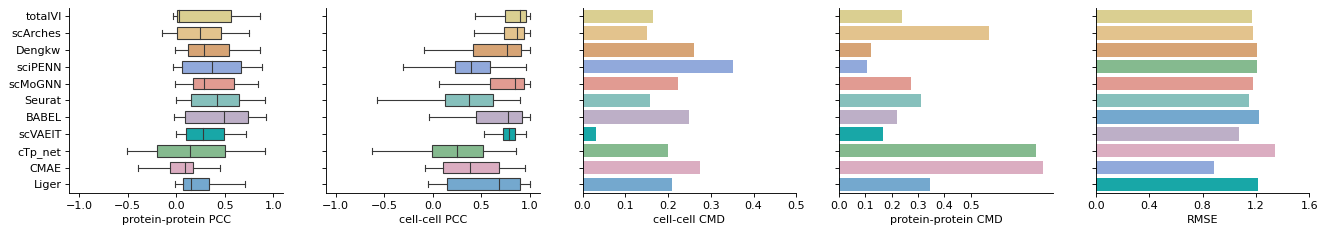

In [46]:
plt.figure(figsize=(20,3), dpi= 80)

ax1 = plt.subplot(151)
ax1 = sns.boxplot(data=PCCs_protein.T,orient = "h",linewidth=1,width=0.7, palette=my_pal,fliersize=0,flierprops = {'marker':'o'})
ax1.set_xlabel("protein-protein PCC")
ax1.set_xlim(-1.1,1.1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(152)
ax2 = sns.boxplot(data=PCCs_cell.T,orient = "h",linewidth=1,width=0.7, palette=my_pal,fliersize=0,flierprops = {'marker':'o'})
ax2.set_xlabel("cell-cell PCC")
ax2.set_xlim(-1.1,1.1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.yticks(alpha=0)

ax3 = plt.subplot(153)
ax3 = sns.barplot(x = "cmd_values",y = CMD_cell.index,orient = "h",data = CMD_cell, ci = 95, palette = my_pal)
ax3.set_xlabel("cell-cell CMD")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xticks(np.arange(0,0.55,0.1))
plt.yticks(alpha=0)

ax4 = plt.subplot(154)
ax4 = sns.barplot(x = "cmd_values",y = CMD_protein.index,orient = "h",data = CMD_protein, ci = 95, palette = my_pal)
ax4.set_xlabel("protein-protein CMD")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_xticks(np.arange(0,0.55,0.1))
plt.yticks(alpha=0)

ax5 = plt.subplot(155)
ax5 = sns.barplot(x = "rmse_values",y = RMSE_Data.index,orient = "h",data = RMSE_Data, ci = 95, palette = my_pal)
ax5.set_xlabel("RMSE")
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.set_xticks(np.arange(0,2,0.4))
plt.yticks(alpha=0)

# plt.savefig("../Results/"+ test_id + "_from_" + train_id +"_total.pdf", bbox_inches="tight")
plt.show()
